In [1]:
import numpy as np
from time import time, localtime, strftime
import matplotlib.pyplot as plt
import tracemalloc

<h3>Helpful functions and constants</h3>

In [2]:
EPS = 1e-10
# factorizations from alpha tensor
fact_file = open("factorizations_r.npz", "rb")
FACTS = dict(np.load(fact_file, allow_pickle=True))

# split matrix into 4 as closely to equal (in size) parts as possible
# A = [ A11 A12 ]
#     [ A21 A22 ]
def split_matrix(A):
    r, c = A.shape
    half_r = r//2
    half_c = c//2
    A11 = A[:half_r, :half_c]
    A12 = A[:half_r, half_c:]
    A21 = A[half_r:, :half_c]
    A22 = A[half_r:, half_c:]
    return A11, A12, A21, A22

# split matrix into custom amount of rows and columns of submatrices
#  return a dict of (r,c) -> Arc submatrix
def split_matrix_custom(A, num_r, num_c):
    r, c = A.shape
    r_div, c_div = r/num_r, c/num_c
    result_dict = {}
    for i in range(num_r):
        for j in range(num_c):
            result_dict[(i,j)] = A[int(i*r_div):int((i+1)*r_div), int(j*c_div):int((j+1)*c_div)]
    return result_dict

# returns count of all elments in matrix
def el_count(A):
    return A.shape[0] * A.shape[1]

# generate matrix N x N with values in given range
def generate_matrix(n, range_start=0.00000001, range_end=1.0):
    A = np.random.rand(n,n)
    diff = range_end-range_start
    return A*diff + range_start

# sparse matrix times a vector with flop counting
def mat_by_vec(A, vec):
    flop_count = 0
    res = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        res[i] = np.sum(A[i]*vec)
        flop_count += 2*len(A[i][A[i] != 0])
    return res, flop_count

# test correctness of method for random matrices of dimensions from N to M
def test_correctness(method, min_dim=1, max_dim=50, tests_per_dim=3):
    test_no = 0
    pass_count = 0
    total_tests = (max_dim-min_dim+1)*tests_per_dim
    for dim in range(min_dim, max_dim+1):
        for t in range(tests_per_dim):
            test_no += 1
            A = generate_matrix(dim)
            B = generate_matrix(dim)
            exp = A@B
            res, _ = method(A,B)
            if np.all(np.abs(exp-res) < EPS):
                pass_count += 1
            else:
                print(f"Didn't pass a test no. {test_no} for dim: {dim}")
    print(f"Passed {pass_count}/{total_tests}")
    return pass_count == total_tests

# result class
class Result:
    def __init__(self, time_elapsed, flop_count, mem_used):
        # time elapsed in ms
        self.time_elapsed = time_elapsed
        # flop count
        self.flop_count = flop_count
        # memory used in KiB
        self.mem_used = mem_used

# test method in regards to speed, flop count and memory usage
def test_method(method, dim):
    A = generate_matrix(dim)
    B = generate_matrix(dim)
    tracemalloc.start()
    t0 = time()
    _, flop_count = method(A, B)
    t1 = time()
    _, mem_used = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(dim, end=' ')
    return Result((t1-t0)*1000, flop_count, mem_used / 1024)

# plot a result
def plot_result(dims, result_label, method_labels, method_results, xscale="linear", yscale="linear"):
    # set figsize
    plt.figure(figsize = (12,8))
    # plot results
    for i in range(len(method_labels)):
        plt.plot(dims, method_results[i], label=method_labels[i])
    # set title and axes names
    plt.title(f"{result_label} by dimension for given methods")
    plt.xlabel("dimension")
    plt.ylabel(result_label)
    # set both axes scales'
    plt.xscale(xscale)
    plt.yscale(yscale)
    # show plot with grid and legend
    plt.grid()
    plt.legend()
    plt.show()

<h3>Binet multiplication</h3>

In [3]:
def binet(A, B):
    flop_count = 0
    
    def f(A, B):
        nonlocal flop_count
        # initialize result matrix as zeros
        C = np.zeros((A.shape[0], B.shape[1]))
        # if matrices can be split further, split them
        if A.shape[0] > 1 and A.shape[1] > 1 and B.shape[1] > 1:
            # split matrices
            A11, A12, A21, A22 = split_matrix(A)
            B11, B12, B21, B22 = split_matrix(B)
            # calculate each part of the result recursively
            C11 = f(A11, B11) + f(A12, B21)
            C12 = f(A11, B12) + f(A12, B22)
            C21 = f(A21, B11) + f(A22, B21)
            C22 = f(A21, B12) + f(A22, B22)
            flop_count += el_count(C11) + el_count(C12) + el_count(C21) + el_count(C22)
            # write the result into new matrix
            half_r, half_c = C11.shape
            C[:half_r, :half_c] = C11
            C[:half_r, half_c:] = C12
            C[half_r:, :half_c] = C21
            C[half_r:, half_c:] = C22
        # if you can no longer split matrices, do normal matrix multiplication
        else:
            for r in range(C.shape[0]):
                for c in range(C.shape[1]):
                    for i in range(A.shape[1]):
                        C[r,c] += A[r,i]*B[i,c]
                        flop_count += 2
        # return resulting matrix
        return C
    
    return f(A, B), flop_count

Test prawidłowości metody

In [4]:
# test binet
test_correctness(binet)

Passed 150/150


True

<h3>Strassen multiplication</h3>

In [5]:
# recursive strassen
def strassen(A, B):
    flop_count = 0
    # pad matrices
    n = A.shape[0]
    size_2n = 1
    while size_2n < n:
        size_2n *= 2
    A_padded = np.zeros((size_2n, size_2n))
    B_padded = np.zeros((size_2n, size_2n))
    A_padded[:n, :n] = A
    B_padded[:n, :n] = B
    
    def f(A, B):
        nonlocal flop_count
        n = A.shape[0]
        # initialize result matrix as zeros
        C = np.zeros((n,n))
        # if matrices can be split further, split them
        if n > 1:
            # split matrices
            A11, A12, A21, A22 = split_matrix(A)
            B11, B12, B21, B22 = split_matrix(B)
            # calculate needed values recursively
            M1 = f(A11+A22, B11+B22)
            M2 = f(A21+A22, B11)
            M3 = f(A11, B12-B22)
            M4 = f(A22, B21-B11)
            M5 = f(A11+A12, B22)
            M6 = f(A21-A11, B11+B12)
            M7 = f(A12-A22, B21+B22)
            flop_count += (n//2)**2 * 10
            # add values to create each part of result matrix
            C11 = M1 + M4 - M5 + M7
            C12 = M3 + M5
            C21 = M2 + M4
            C22 = M1 - M2 + M3 + M6
            flop_count += (n//2)**2 * 8
            # write the result into new matrix
            half_r, half_c = C11.shape
            C[:half_r, :half_c] = C11
            C[:half_r, half_c:] = C12
            C[half_r:, :half_c] = C21
            C[half_r:, half_c:] = C22
        # if you can no longer split matrices, it's 1x1 by 1x1
        else:
            C[0,0] = A[0,0]*B[0,0]
            flop_count += 1
        # return resulting matrix
        return C

    return f(A_padded, B_padded)[:n, :n], flop_count

Test prawidłowości metody

In [6]:
# test strassen
test_correctness(strassen)

Passed 150/150


True

<h3>AI multiplication</h3>

In [7]:
# ai
def ai(A, B):
    flop_count = 0
    
    def f(A, B):
        nonlocal flop_count
        # initialize result matrix as zeros
        C = np.zeros((A.shape[0], B.shape[1]))
        shape_string = f"{A.shape[0]},{A.shape[1]},{B.shape[1]}"
        # if matrix sizes are in factorizations, multiply them
        if shape_string in FACTS:
            u, v, w = FACTS[shape_string]
            # create vectors representing matrices
            A_vec = A.reshape(-1)
            B_vec = B.reshape(-1)
            # calculate Ms
            A_part, f1 = mat_by_vec(u.T, A_vec)
            B_part, f2 = mat_by_vec(v.T, B_vec)
            M = A_part * B_part
            # create a vector of result and reshape it
            C_vec, f3 = mat_by_vec(w, M)
            flop_count += f1 + f2 + f3 + len(M)
            C = C_vec.reshape(A.shape[0], B.shape[1], order='F')
        # if they cannot be split further, multiply them normally
        elif A.shape[0] == 1 or A.shape[1] == 1 or B.shape[1] == 1:
            for r in range(C.shape[0]):
                for c in range(C.shape[1]):
                    for i in range(A.shape[1]):
                        C[r,c] += A[r,i]*B[i,c]
                        flop_count += 2
        # if not, split them using classic binet
        else:
            # split matrices
            A11, A12, A21, A22 = split_matrix(A)
            B11, B12, B21, B22 = split_matrix(B)
            # calculate each part of the result recursively
            C11 = f(A11, B11) + f(A12, B21)
            C12 = f(A11, B12) + f(A12, B22)
            C21 = f(A21, B11) + f(A22, B21)
            C22 = f(A21, B12) + f(A22, B22)
            flop_count += el_count(C11) + el_count(C12) + el_count(C21) + el_count(C22)
            # write the result into new matrix
            half_r, half_c = C11.shape
            C[:half_r, :half_c] = C11
            C[:half_r, half_c:] = C12
            C[half_r:, :half_c] = C21
            C[half_r:, half_c:] = C22
        # return resulting matrix
        return C
    
    return f(A, B), flop_count

Test prawidłowości metody

In [8]:
# test ai
test_correctness(ai)

Passed 150/150


True

<h3>Testy jakościowe metod</h3>

Testing binet...
Start: 22:05:52
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 60 70 80 90 100 120 140 160 180 200 300 400 500 
End: 23:23:12
Finished testing in 4639.467436552048s
Testing strassen...
Start: 23:23:12
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 60 70 80 90 100 120 140 160 180 200 300 400 500 
End: 00:06:51
Finished testing in 2619.245370864868s
Testing ai...
Start: 00:06:51
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 60 70 80 90 100 120 140 160 180 200 300 400 500 
End: 02:14:48
Finished testing in 7677.296739578247s


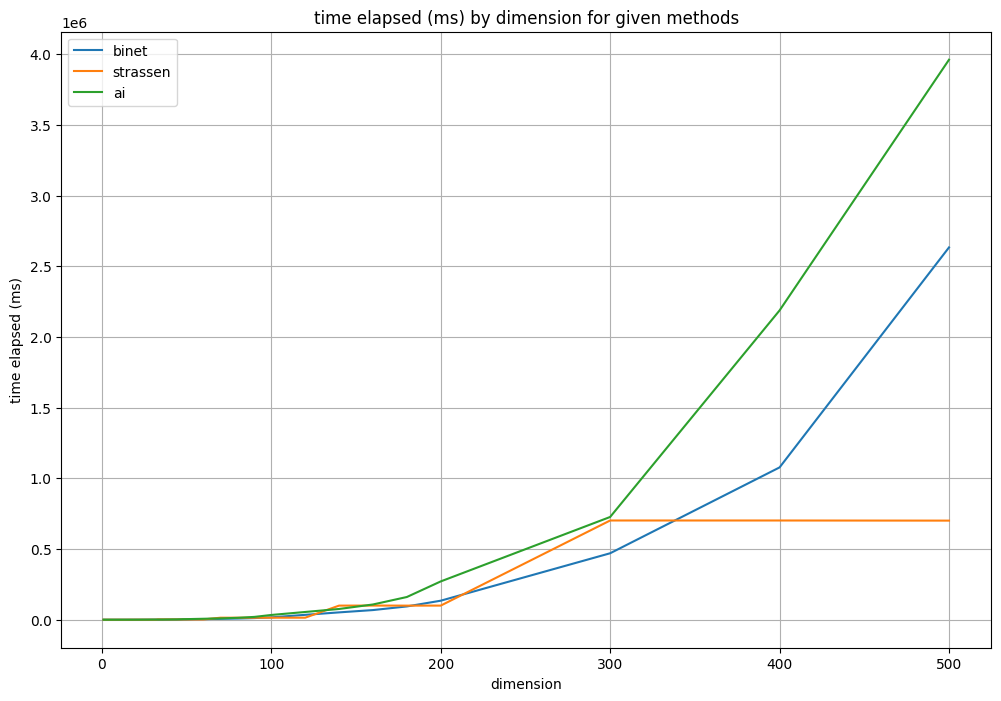

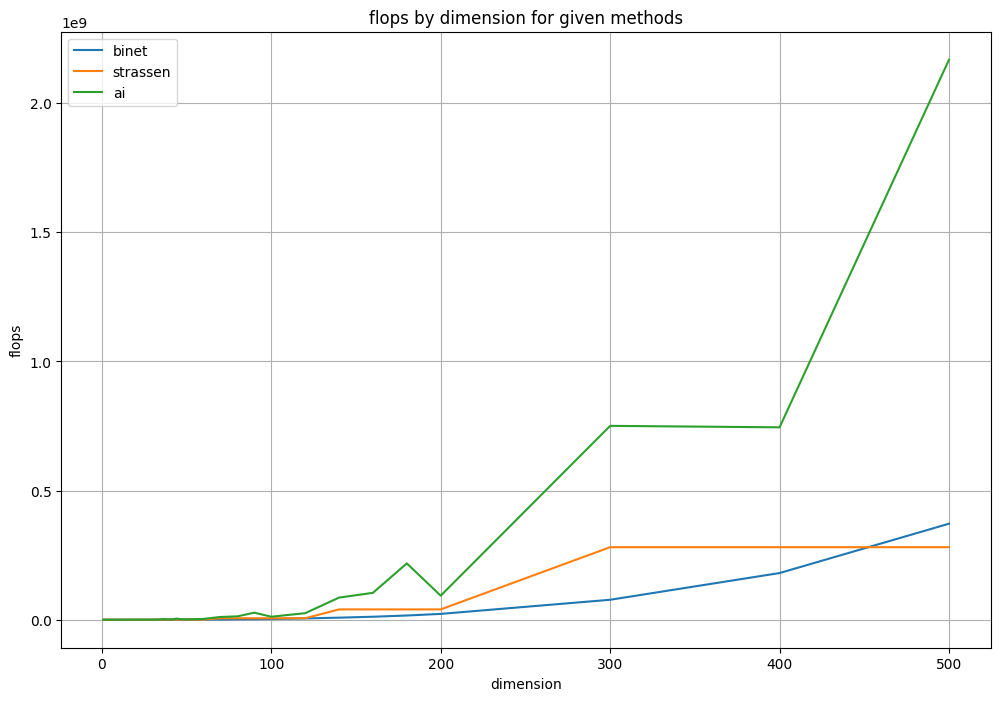

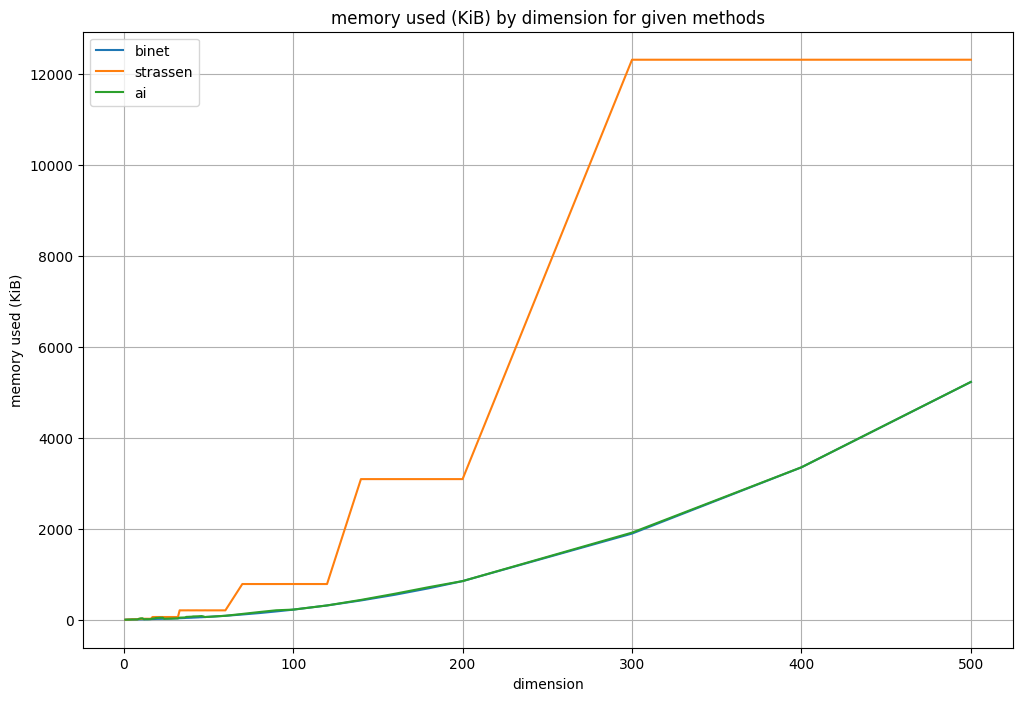

In [9]:
# test by 1 until 50
dims = np.arange(1, 51, 1)
# test by 10 until 100
dims = np.append(dims, np.arange(60, 101, 10))
# test by 20 until 200
dims = np.append(dims, np.arange(120, 201, 20))
# test 300, 400 and 500
dims = np.append(dims, [300, 400, 500])

# test methods
def test_and_time(method, dims):
    print(f"Start: {strftime("%H:%M:%S", localtime())}")
    t0 = time()
    result = [test_method(method, dim) for dim in dims]
    t1 = time()
    print(f"\nEnd: {strftime("%H:%M:%S", localtime())}")
    print(f"Finished testing in {t1-t0}s")
    return result

print("Testing binet...")
binet_results = test_and_time(binet, dims)
print("Testing strassen...")
strassen_results = test_and_time(strassen, dims)
print("Testing ai...")
ai_results = test_and_time(ai, dims)

method_labels = ["binet", "strassen", "ai"]
method_results = [binet_results, strassen_results, ai_results]

# plot time by dim
plot_result(
    dims,
    "time elapsed (ms)",
    method_labels,
    [[r.time_elapsed for r in res] for res in method_results]
)

# plot flops by dim
plot_result(
    dims,
    "flops",
    method_labels,
    [[r.flop_count for r in res] for res in method_results]
)

# plot memory used by dim
plot_result(
    dims,
    "memory used (KiB)",
    method_labels,
    [[r.mem_used for r in res] for res in method_results]
)